In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import numpy as np
import gc
import os
import optuna
import sqlite3
import ray
import matplotlib.pyplot as plt
from optuna.integration import LightGBMPruningCallback
from autogluon.tabular import TabularPredictor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
gc.collect()
df_full = pd.read_parquet('./data/l_vm_completa_normalizada_fe.parquet', engine='fastparquet')

In [3]:
# Variables predictoras y objetivo
# filtrar que en X el periodo sea menor o igual a 201910
# En x eliminar la columna 'CLASE_ZSCORE' y 'CLASE_DELTA_ZSCORE' si existen
cols_to_drop = [col for col in ['CLASE_ZSCORE', 'CLASE_DELTA_ZSCORE','CLASE_ZSCORE_CLIP', 'CLASE_DELTA_ZSCORE_CLIP'] if col in df_full.columns]
X = df_full[df_full['PERIODO'] <= 201910].drop(columns=cols_to_drop)
# Filtrar en y que el periodo sea menor o igual a 201910 y que la columna exista
y = df_full[df_full['PERIODO'] <= 201910]['CLASE_DELTA_ZSCORE_CLIP']
# Eliminar df_full para liberar memoria
del df_full
gc.collect()

48

In [4]:
# Definir los periodos de validación 
periodos_valid = [201909, 201910]

# Separar train y cinco conjuntos de validación respetando la secuencia temporal
X_train = X[X['PERIODO'] < periodos_valid[0]]
y_train = y[X['PERIODO'] < periodos_valid[0]]
X_val_list = [X[X['PERIODO'] == p] for p in periodos_valid]
y_val_list = [y[X['PERIODO'] == p] for p in periodos_valid]
del X, y
gc.collect()

0

In [5]:
from autogluon.tabular import TabularPredictor

# Dataset de entrenamiento
df_train = X_train.copy()
df_train['CLASE_DELTA_ZSCORE_CLIP'] = y_train

# Dataset de validación
df_val = X_val_list[0].copy()
df_val['CLASE_DELTA_ZSCORE_CLIP'] = y_val_list[0]

In [6]:
""" import datetime
import gc
from autogluon.tabular import TabularPredictor

gc.collect()

# === Configuración general ===
label_column = 'CLASE_DELTA_ZSCORE_CLIP'
output_path = f"AutogluonModels/model_fast_{datetime.datetime.now().strftime('%Y%m%d_%H%M')}"

# === Entrenamiento ===
predictor = TabularPredictor(
    label=label_column,
    problem_type='regression',
    eval_metric='mean_absolute_error',
    path=output_path
).fit(
    train_data=df_train,
    tuning_data=df_val,
    use_bag_holdout=True,
    presets='medium_quality',               # Entrenamiento rápido pero razonable
    time_limit=1800,                         # ⏱️ Máximo 15 minutos (900 segundos)
    num_bag_folds=3,                        # Reduce cantidad de folds
    num_bag_sets=1,                         # Una sola pasada
    auto_stack=False,                       # Apagar stacking para acelerar
    ag_args_ensemble={'fold_fitting_strategy': 'parallel_local'},
    hyperparameters={
        'GBM': [
            {
                'ag_args': {'name_suffix': 'QuickXT'},
                'extra_trees': True,
                'time_limit': 300,
                'early_stopping_rounds': 10,
            },
            {
                'ag_args': {'name_suffix': 'QuickDefault'},
                'num_leaves': 31,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'time_limit': 300,
                'early_stopping_rounds': 10,
            }
        ]
    },
    verbosity=2
)
 """

' import datetime\nimport gc\nfrom autogluon.tabular import TabularPredictor\n\ngc.collect()\n\n# === Configuración general ===\nlabel_column = \'CLASE_DELTA_ZSCORE_CLIP\'\noutput_path = f"AutogluonModels/model_fast_{datetime.datetime.now().strftime(\'%Y%m%d_%H%M\')}"\n\n# === Entrenamiento ===\npredictor = TabularPredictor(\n    label=label_column,\n    problem_type=\'regression\',\n    eval_metric=\'mean_absolute_error\',\n    path=output_path\n).fit(\n    train_data=df_train,\n    tuning_data=df_val,\n    use_bag_holdout=True,\n    presets=\'medium_quality\',               # Entrenamiento rápido pero razonable\n    time_limit=1800,                         # ⏱️ Máximo 15 minutos (900 segundos)\n    num_bag_folds=3,                        # Reduce cantidad de folds\n    num_bag_sets=1,                         # Una sola pasada\n    auto_stack=False,                       # Apagar stacking para acelerar\n    ag_args_ensemble={\'fold_fitting_strategy\': \'parallel_local\'},\n    hyperpa

In [7]:
predictor = TabularPredictor.load("AutogluonModels/model_fast_20250629_0112")


In [8]:
predictor.fit_extra(
    time_limit=1800,  # 30 minutos
    ag_args_ensemble={
        'fold_fitting_strategy': 'sequential_local',
        'num_bag_folds': 1  # 👈 solo 1 fold para asegurar que termine
    },
    fit_weighted_ensemble=True,
    hyperparameters={
        'NN_TORCH': [{
            'num_epochs': 4,
            'learning_rate': 0.01,
            'dropout_prob': 0.1,
            'weight_decay': 1e-5,
            'batch_size': 256,
            'hidden_size': 128,
            'ag_args': {'name_suffix': 'NN_LightFast'},
            'ag_args_fit': {
                'num_gpus': 1,  # Usa GPU si está disponible
            }
        }]
    },
    verbosity=2
)

Fitting 1 L1 models, fit_strategy="sequential" ...
Fitting model: NeuralNetTorchNN_LightFast_BAG_L1 ... Training model for up to 1800.00s of the 1800.00s of remaining time.
	Fitting 3 child models (S1F1 - S1F3) | Fitting with SequentialLocalFoldFittingStrategy
	-0.1751	 = Validation score   (-mean_absolute_error)
	1013.72s	 = Training   runtime
	12.7s	 = Validation runtime
Fitting model: WeightedEnsemble_2_L2 ... Training model for up to 360.00s of the 642.19s of remaining time.
	Ensemble Weights: {'NeuralNetTorchNN_LightFast_BAG_L1': 1.0}
	-0.1751	 = Validation score   (-mean_absolute_error)
	0.0s	 = Training   runtime
	0.0s	 = Validation runtime
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/home/pablo/Documentos/labo3-2025v/AutogluonModels/model_fast_20250629_0112")


In [26]:
predictor.fit_extra(
    time_limit=600,  
    ag_args_ensemble={'fold_fitting_strategy': 'parallel_local'},
    fit_weighted_ensemble=True,
    hyperparameters={
        'CAT': [{'ag_args': {'name_suffix': 'CAT_Quick'}
        }]
    },
    verbosity=2
)

Fitting 1 L1 models, fit_strategy="sequential" ...
Fitting model: CatBoostCAT_Quick_2_BAG_L1 ... Training model for up to 600.00s of the 600.00s of remaining time.
	Memory not enough to fit 3 folds in parallel. Will train 1 folds in parallel instead (Estimated 42.94% memory usage per fold, 42.94%/80.00% total).
	Fitting 3 child models (S1F1 - S1F3) | Fitting with ParallelLocalFoldFittingStrategy (1 workers, per: cpus=20, gpus=0, memory=42.94%)
2025-06-29 12:33:44,871	ERROR services.py:1350 -- Failed to start the dashboard , return code 0
2025-06-29 12:33:44,875	ERROR services.py:1375 -- Error should be written to 'dashboard.log' or 'dashboard.err'. We are printing the last 20 lines for you. See 'https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#logging-directory-structure' to find where the log file is.
2025-06-29 12:33:44,877	ERROR services.py:1419 -- 
The last 20 lines of /tmp/ray/session_2025-06-29_12-33-43_778435_23801/logs/dashboard.log (it contain

In [27]:
predictor.fit_extra(
    time_limit=600,  
    ag_args_ensemble={'fold_fitting_strategy': 'parallel_local'},
    fit_weighted_ensemble=True,
    hyperparameters={
        'XGB': [{
            'n_estimators': 150,
            'early_stopping_rounds': 10,
            'learning_rate': 0.05,
            'booster': 'gbtree',
            'ag_args': {'name_suffix': 'XGB_Quick'}
        }]
    },
    verbosity=2
)

Fitting 1 L1 models, fit_strategy="sequential" ...
Fitting model: XGBoostXGB_Quick_BAG_L1 ... Training model for up to 600.00s of the 600.00s of remaining time.
	Memory not enough to fit 3 folds in parallel. Will train 1 folds in parallel instead (Estimated 60.64% memory usage per fold, 60.64%/80.00% total).
	Fitting 3 child models (S1F1 - S1F3) | Fitting with ParallelLocalFoldFittingStrategy (1 workers, per: cpus=20, gpus=0, memory=60.64%)
		Switching to pseudo sequential ParallelFoldFittingStrategy to avoid Python memory leakage.
		Overrule this behavior by setting fold_fitting_strategy to 'sequential_local' in ag_args_ensemble when when calling `predictor.fit`
		Task was killed due to the node running low on memory.
Memory on the node (IP: 192.168.49.109, ID: f8849383e1aa21045da08a7bcc3085e5cf9591c726e50555f04e4406) where the task (task ID: 433b77321b079d457ea4cfaa82248693c455cf8b01000000, name=_ray_fit, pid=66316, memory used=37.98GB) was running was 119.33GB / 125.58GB (0.950234),

In [ ]:
predictor.fit_extra(
    time_limit=7200,  # 2 horas
    ag_args_ensemble={
        'fold_fitting_strategy': 'sequential_local',
        'num_bag_folds': 3
    },
    fit_weighted_ensemble=True,
    hyperparameters={
        'NN_TORCH': [
            {
                'num_epochs': 10,  # Base, puede ser sobreescrito
                'learning_rate': 0.005,
                'dropout_prob': 0.2,
                'weight_decay': 1e-4,
                'batch_size': 512,
                'hidden_size': 256,
                'ag_args': {'name_suffix': 'NN_HPO'},
                'ag_args_fit': {'num_gpus': 1}
            }
        ]
    },
    hyperparameter_tune_kwargs={
        'num_trials': 15,              # N° de combinaciones a probar
        'scheduler': 'fifo',           # Simples y seguros para 1 GPU
        'searcher': 'random',          # Búsqueda aleatoria (rápida)
    },
    verbosity=2
)


In [ ]:
""" import datetime
gc.collect()
# === Configuración general ===
label_column = 'CLASE_DELTA_ZSCORE_CLIP'
output_path = f"AutogluonModels/model_gbm_{datetime.datetime.now().strftime('%Y%m%d_%H%M')}"

# === Entrenamiento ===
predictor = TabularPredictor(
    label=label_column,
    problem_type='regression',
    eval_metric='mean_absolute_error',
    path=output_path
).fit(
    train_data=df_train,
    tuning_data=df_val,
    use_bag_holdout=True,
    presets='medium_quality',
    num_bag_folds=8,         # Mayor robustez
    num_bag_sets=2,          # Mejor estimación out-of-fold
    auto_stack=True,         # Activar stacking desde el inicio
    time_limit=10800,
    ag_args_ensemble={'fold_fitting_strategy': 'parallel_local'},
    hyperparameters={
        'GBM': [
            {
                'ag_args': {'name_suffix': 'XT'},
                'extra_trees': True,
                'time_limit': 600,
                'early_stopping_rounds': 20,
            },
            {
                'ag_args': {'name_suffix': 'LinearTree'},
                'linear_tree': True,
                'time_limit': 600,
                'early_stopping_rounds': 20,
            },
            {
                'ag_args': {'name_suffix': 'Default'},
                'num_leaves': 31,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'time_limit': 600,
                'early_stopping_rounds': 20,
            }
        ]
    }
)
 """

In [ ]:
# # === Cargar modelo ya entrenado ===
# #predictor = TabularPredictor.load("AutogluonModels/model_gbm")

# predictor.fit_extra(
#     time_limit=10800,  # Tiempo total disponible para todos los modelos nuevos
#     ag_args_ensemble={'fold_fitting_strategy': 'parallel_local'},
#     fit_weighted_ensemble=True,  # Activar Weighted Ensemble
#     hyperparameters={
#         'XGB': [{
#             'n_estimators': 1000,
#             'early_stopping_rounds': 25,
#             'learning_rate': 0.03,
#             'booster': 'gbtree',
#             'ag_args': {'name_suffix': 'XGB_Custom'}
#         }],
#         'CAT': [{
#             'ag_args_fit': {'time_limit': 1200},
#             'ag_args': {'name_suffix': 'CAT_Custom'}
#         }],
#         'NN_TORCH': [{
#             'num_epochs': 50,
#             'learning_rate': 0.003,
#             'layers': [1024, 512, 256],
#             'dropout_prob': 0.3,
#             'weight_decay': 1e-5,
#             'batch_size': 2048,
#             'ag_args': {'name_suffix': 'DeepCustom'},
#             'ag_args_fit': {'num_gpus': 1}
#         }]
#     },
#     verbosity=2
# )


In [9]:
# Comparar MAE y MedAE en el leaderboard
lb = predictor.leaderboard(data = df_val, extra_metrics=['mean_absolute_error', 'median_absolute_error', 'r2'], silent=False)

                               model  score_test  mean_absolute_error  median_absolute_error        r2  score_val          eval_metric  pred_time_test  pred_time_val     fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  NeuralNetTorchNN_LightFast_BAG_L1   -0.175089            -0.175089              -0.004558  0.408446  -0.175089  mean_absolute_error       12.704504      12.703439  1013.719818                12.704504               12.703439        1013.719818            1       True          5
1              WeightedEnsemble_2_L2   -0.175089            -0.175089              -0.004558  0.408446  -0.175089  mean_absolute_error       12.706980      12.705760  1013.723721                 0.002477                0.002322           0.003903            2       True          6
2                WeightedEnsemble_L2   -0.196502            -0.196502              -0.029611  0.512068  -0.196502  mean_absolute_error        2.710076    

In [16]:
ensemble_model = predictor._trainer.load_model(best_model)
weights = getattr(ensemble_model, 'weights', None)
print(f"Best model: {best_model}")
print(weights)


Best model: NeuralNetTorchNN_LightFast_BAG_L1
None


In [17]:
# Evaluar feature importance sobre el conjunto de validación
importancia = predictor.feature_importance(df_val)

These features in provided data are not utilized by the predictor and will be ignored: ['TN_DELTA_01_ZSCORE_CLIP', 'TN_LAG_10_ZSCORE_CLIP', 'TN_DELTA_10_ZSCORE_CLIP', 'TN_LAG_11_ZSCORE_CLIP', 'TN_DELTA_11_ZSCORE_CLIP', 'TN_LAG_12_ZSCORE_CLIP', 'TN_DELTA_12_ZSCORE_CLIP', 'TN_LAG_13_ZSCORE_CLIP', 'TN_DELTA_13_ZSCORE_CLIP', 'TN_LAG_14_ZSCORE_CLIP', 'TN_DELTA_14_ZSCORE_CLIP', 'TN_LAG_15_ZSCORE_CLIP', 'TN_DELTA_15_ZSCORE_CLIP', 'TN_LAG_16_ZSCORE_CLIP', 'TN_DELTA_16_ZSCORE_CLIP', 'TN_LAG_17_ZSCORE_CLIP', 'TN_DELTA_17_ZSCORE_CLIP', 'TN_LAG_18_ZSCORE_CLIP', 'TN_DELTA_18_ZSCORE_CLIP', 'TN_LAG_19_ZSCORE_CLIP', 'TN_DELTA_19_ZSCORE_CLIP', 'TN_LAG_20_ZSCORE_CLIP', 'TN_DELTA_20_ZSCORE_CLIP', 'TN_LAG_21_ZSCORE_CLIP', 'TN_DELTA_21_ZSCORE_CLIP', 'TN_LAG_22_ZSCORE_CLIP', 'TN_DELTA_22_ZSCORE_CLIP', 'TN_LAG_23_ZSCORE_CLIP', 'TN_DELTA_23_ZSCORE_CLIP', 'TN_LAG_24_ZSCORE_CLIP', 'TN_DELTA_24_ZSCORE_CLIP', 'TN_LAG_25_ZSCORE_CLIP', 'TN_DELTA_25_ZSCORE_CLIP', 'TN_LAG_26_ZSCORE_CLIP', 'TN_DELTA_26_ZSCORE_CLIP', '

In [18]:
importancia

,importance,stddev,p_value,n,p99_high,p99_low
TN_DELTA_02_ZSCORE_CLIP,0.011183,0.000744,0.000002,5,0.012716,0.009650
TN_DELTA_02_ZSCORE,0.011078,0.000732,0.000002,5,0.012584,0.009572
PENDIENTE_TENDENCIA_ZSCORE_2,0.007918,0.000581,0.000003,5,0.009114,0.006723
CUST_REQUEST_QTY,0.005552,0.000412,0.000004,5,0.006400,0.004703
PENDIENTE_TENDENCIA_ZSCORE_3,0.004213,0.000292,0.000003,5,0.004814,0.003611
...,...,...,...,...,...,...
TN_LAG_04_ZSCORE,-0.000140,0.000029,0.999805,5,-0.000081,-0.000199
TN_LAG_05_ZSCORE,-0.000159,0.000129,0.974471,5,0.000107,-0.000425
ID_CAT1,-0.000197,0.000076,0.997830,5,-0.000041,-0.000352
TN_MIN_ZSCORE_02,-0.000202,0.000129,0.987471,5,0.000064,-0.000469


✅ Paso 1: Calcular errores de predicción

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predicciones y error absoluto
df_val['y_true'] = df_val['CLASE_DELTA_ZSCORE_CLIP']
df_val['y_pred'] = predictor.predict(df_val)
df_val['error_abs'] = abs(df_val['y_true'] - df_val['y_pred'])
df_val['error_signed'] = df_val['y_pred'] - df_val['y_true']


📊 Paso 2: Histogramas de error absoluto y error signado

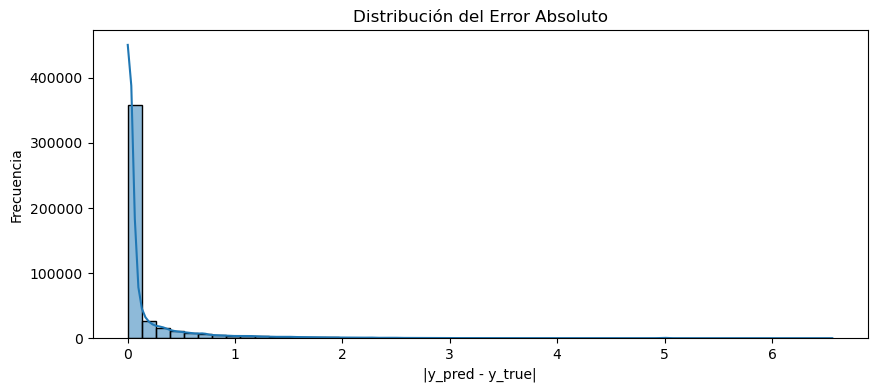

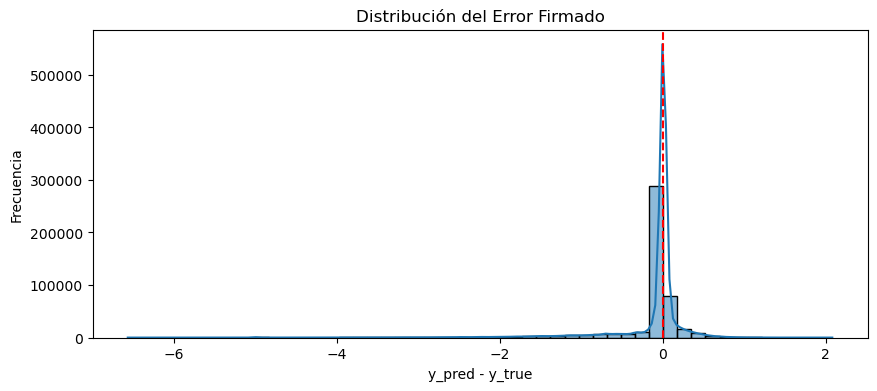

In [ ]:
plt.figure(figsize=(10, 4))
sns.histplot(df_val['error_abs'], bins=50, kde=True)
plt.title('Distribución del Error Absoluto')
plt.xlabel('|y_pred - y_true|')
plt.ylabel('Frecuencia')
plt.show()

plt.figure(figsize=(10, 4))
sns.histplot(df_val['error_signed'], bins=50, kde=True)
plt.title('Distribución del Error Signado')
plt.xlabel('y_pred - y_true')
plt.ylabel('Frecuencia')
plt.axvline(0, color='red', linestyle='--')
plt.show()


📈 Paso 3: Error vs. Valor real (dispersión)


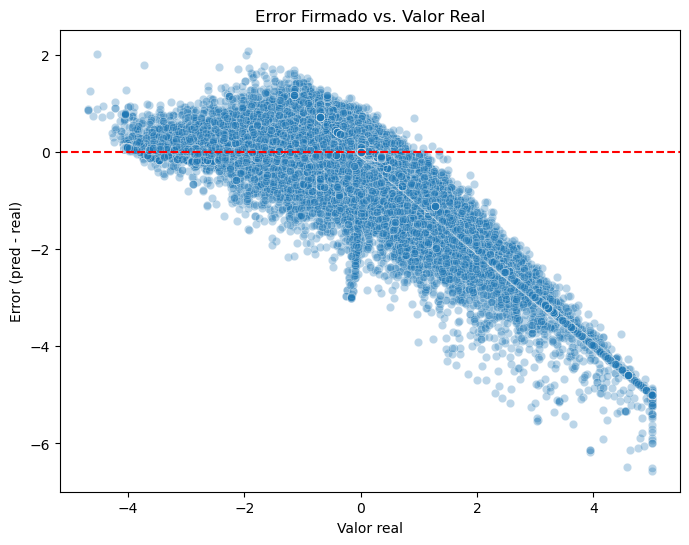

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_val['y_true'], y=df_val['error_signed'], alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title('Error Signado vs. Valor Real')
plt.xlabel('Valor real')
plt.ylabel('Error (pred - real)')
plt.show()


🧩 Paso 4: Promedio de error por grupo 

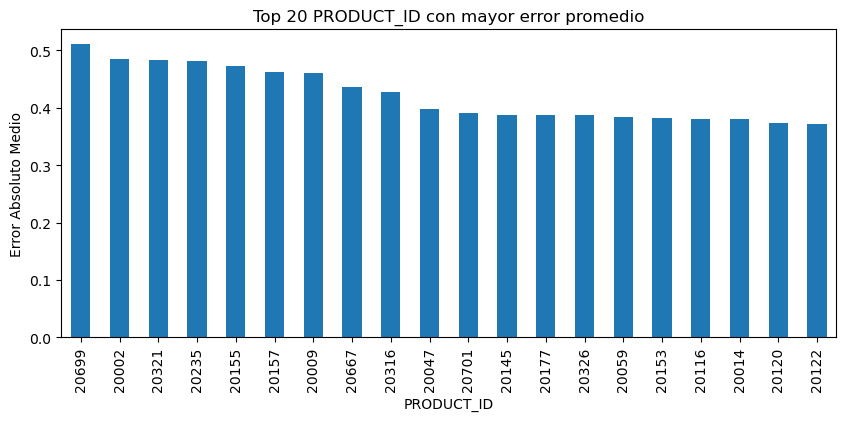

In [25]:
top_errores_producto = df_val.groupby('PRODUCT_ID')['error_abs'].mean().sort_values(ascending=False).head(20)
top_errores_producto.plot(kind='bar', figsize=(10,4), title='Top 20 PRODUCT_ID con mayor error promedio')
plt.ylabel('Error Absoluto Medio')
plt.show()


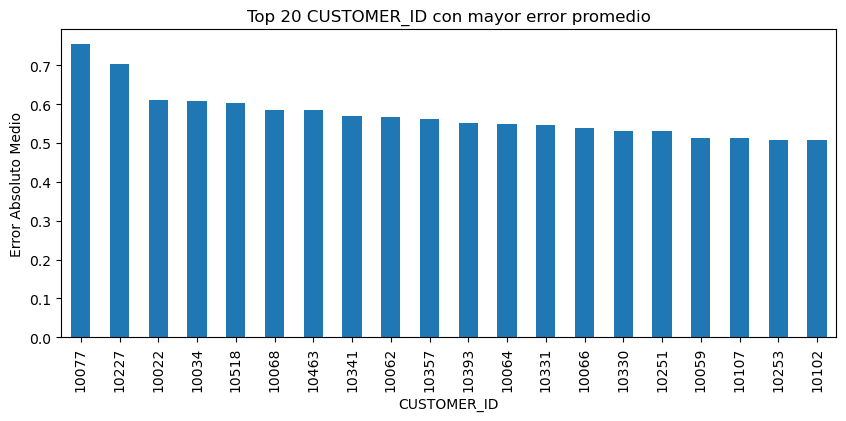

In [24]:
top_errores_producto = df_val.groupby('CUSTOMER_ID')['error_abs'].mean().sort_values(ascending=False).head(20)
top_errores_producto.plot(kind='bar', figsize=(10,4), title='Top 20 CUSTOMER_ID con mayor error promedio')
plt.ylabel('Error Absoluto Medio')
plt.show()

In [ ]:
# Combinar entrenamiento + validación
df_full = pd.concat([df_train, df_val], axis=0)
del df_train, df_val
gc.collect()

In [ ]:
# Reentrenar el mejor modelo con TODOS los datos disponibles
predictor_full = predictor.refit_full(train_data=df_full)

In [ ]:
# Verificar los modelos disponibles (el mejor ahora tiene el sufijo '_FULL')
print("Modelos disponibles luego del refit completo:")
print(predictor.leaderboard(silent=True)['model'].tolist())
# Eliminar modelos intermedios para liberar espacio
predictor.delete_models(models_to_keep='best', dry_run=False)

# Confirmar que solo queda el modelo reentrenado
print("\nModelos restantes después de eliminar los intermedios:")
print(predictor.leaderboard(silent=True)['model'].tolist())

# (Opcional) Guardar el predictor final si querés usarlo luego sin volver a cargar todo
predictor.save('./data/modelo_final_autogluon')

# ---  Liberar memoria ---
del df_full
gc.collect()


In [ ]:
# Cargo los datos sobre los que quiero hacer predicciones
df_pred_full = pd.read_parquet('./data/l_vm_completa_normalizada_fe.parquet', engine='fastparquet')
# Dejo solo los datos del periodo 201910 y que A_PREDECIR sea True
# Filtrar solo los datos del periodo 201910 y donde A_PREDECIR sea True
df_pred_full = df_pred_full[
    (df_pred_full['PERIODO'] == 201910) & (df_pred_full['A_PREDECIR'] == True)
].drop(columns=['CLASE_ZSCORE', 'CLASE_DELTA_ZSCORE'])

In [ ]:
# Realizar las predicciones usando el predictor original
predictions = predictor.predict(df_pred_full)
# Agregar las predicciones al DataFrame original
df_pred_full['CLASE_DELTA_ZSCORE'] = predictions

In [ ]:
# Imprimir la lista de columas del DataFrame con las predicciones
print("Columnas del DataFrame con las predicciones:")
print(df_pred_full.columns.tolist())

In [ ]:
# Dernormalizar la columna CLASE_DELTA_ZSCORE
df_pred_full['CLASE_DELTA'] = df_pred_full['CLASE_DELTA_ZSCORE'] * df_pred_full['CLASE_DELTA_STD'] + df_pred_full['CLASE_DELTA_MEAN']
df_pred_full['TN'] = df_pred_full['TN_ZSCORE'] * df_pred_full['TN_STD'] + df_pred_full['TN_MEAN']
# Agregar la columna TN_PREDICT que sea la suma de TN y CLASE_DELTA y si es menor que cero, poner cero
df_pred_full['TN_PREDICT'] = df_pred_full['TN'] + df_pred_full['CLASE_DELTA']
df_pred_full['TN_PREDICT'] = df_pred_full['TN_PREDICT'].clip(lower=0)

In [ ]:
# Generar Dataframe que contenga por cada PRODUCT_ID la suma de TN_PREDICT
df_final = df_pred_full.groupby('PRODUCT_ID').agg({'TN_PREDICT': 'sum'}).reset_index()
df_final = df_final.rename(columns={'PRODUCT_ID': 'product_id', 'TN_PREDICT': 'tn'})
# Guardar el DataFrame df_final en un archivo CSV
df_final.to_csv('./modelos/autoglun_normalizando_clase_delta.csv', index=False)
df_final.shape
